# A/B/C-тестирование новой модели прогноза времени ожидания в сервисе такси «Карету мне»

## Бизнес-контекст

Дискавери показало, что пассажиры чаще отменяют заказы, если предварительное время ожидания машины не совпадает с реальным. Пользователи видят, что такси не успевает к обещанному времени, и отменяют заказы. Если предварительное и реальное время ожидания значительно различаются, пользователь может отменить заказ сразу.

Для решения проблемы в компании разработали новую математическую модель, которая должна более точно прогнозировать время ожидания.

Гипотеза продуктовой команды звучит так: «Более точный прогноз времени ожидания повысит качество пользовательского опыта. Это, в свою очередь, увеличит вероятность того, что заказ завершится поездкой».

Сейчас модель реализована в двух вариантах, которые имеют небольшие различия. Аналитику нужно проверить гипотезу с помощью A/B/C-эксперимента и проанализировать результаты. 

**Ваши задачи:** 

- Определить и рассчитать параметры теста.
- Оценить корректность проведения теста.
- Проанализировать результаты теста.
- Создайте новую копию шаблона эксперимента и заполняйте его по мере выполнения заданий. 

**Описание данных**

Работаем с 3 таблицами:

**`users`** — таблица с метаданными зарегистрированных пользователей приложения за период с 2024-01-01 по 2024-10-27;

**`events`** — таблица с пользовательскими событиями в приложении за период с 2024-09-23 по 2024-10-27;

**`orders`** — таблица с метаданными о поездках пользователей за период с 2024-09-23 по 2024-10-27.

**Таблица `users`:**

`user_id` — уникальный идентификатор пользователя;

`registration_date` — дата регистрации в сервисе;

`country_code` — код страны пользователя (RU, BY, KZ, UZ);

`traffic_type` — источник привлечения пользователя в сервис (organic, paid, referral);

`platform` — платформа пользователя (android, ios).

**Таблица `events`:**

`user_id` — уникальный идентификатор пользователя;

`time` — время события;

`session_id` — идентификатор сессии;

`event_name` — название события;

`app_start` — запуск приложения;

`registration_complete` — прохождение регистрации;

`order_initiate` — открытие экрана заказа;

`order_create` — создание заказа;

`order_cancel` — отмена заказа;

`order_rate` — выставление оценки заказу.

**Таблица `orders`:**

`user_id` — уникальный идентификатор пользователя;

`order_id` — уникальный идентификатор заказа;

`order_time` — время создания заказа;

`ride_start_time` — время старта поездки;

`ride_finish_time` — время завершения поездки;

`status` — статус заказа (completed, cancelled_order_by_client, cancelled_order_by_driver);

`paid_amt` — стоимость заказа;

`payment_type` — тип оплаты (cash, card, na).


## Подготовка к тесту

**Выбор метрик:**
- **Ключевая метрика:** конверсия из создания заказа в успешную поездку (отражает вероятность завершения заказа)
- **Барьерная метрика:** выручка на пользователя (чтобы отследить негативное влияние на доход)
- **Вспомогательные метрики:** конверсия из просмотра формы в создание заказа; количество поездок на пользователя

**Дополнительные условия:**
- Поправка на множественное тестирование (Бонферрони)
- Линеаризация ключевой метрики (ratio-метрика)

## Дизайн теста

### Расчет MDE

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.stats import ttest_ind

In [2]:
# Загружаем данные
orders = pd.read_csv('тут_была_ссылка')
orders['order_time'] = pd.to_datetime(orders['order_time'])

# Параметры для расчёта 
alpha =  0.05 / 3
beta = 0.2
group_count =  3
rollout_share = 40  # % трафика на эксперимент (нужно изменять и смотреть на результат)

# Зададим названия столбцов для числителя и знаменателя
unit_name = 'user_id'
numerator = 'completed_orders'
denominator = 'total_orders'

# Предпериод
start_date = pd.Timestamp('2024-09-23 00:00:00')
end_date = pd.Timestamp('2024-10-06 23:59:59')

# Фильтрация и агрегация данных
data_exp_orders = orders[
   (orders['order_time'] >= start_date) &
   (orders['order_time'] <= end_date) &
   (orders['status'] != 'cancelled_order_by_driver')]
completed_orders = data_exp_orders[data_exp_orders['status'] == 'completed'].groupby('user_id')[
   'order_id'].nunique().reset_index()
completed_orders = completed_orders.rename(columns={'order_id': 'completed_orders'})
total_orders = data_exp_orders.groupby('user_id')['order_id'].nunique().reset_index()
total_orders = total_orders.rename(columns={'order_id': 'total_orders'})
df_merged = pd.merge(completed_orders, total_orders, how='outer', on='user_id')
df_merged.fillna(0, inplace=True)

# Расчёт глобального значения метрики
global_ratio = df_merged[numerator].sum() / df_merged[denominator].sum()

# Линеаризация
df_merged['linearized_metric'] = df_merged[numerator] - global_ratio * df_merged[denominator]

# Размер выборки
n_total = len(df_merged) * (rollout_share / 100)
n = n_total / group_count
degrees_of_freedom = n_total - group_count

# Статистики по линеаризованной метрике
std = df_merged['linearized_metric'].std()
mean = df_merged['linearized_metric'].mean()

# Критические значения t-распределения
t_alpha = t.ppf(1 - alpha / 2, degrees_of_freedom)
t_beta = t.ppf(1 - beta, degrees_of_freedom)

# Расчет MDE
left_factor = (t_alpha + t_beta) ** 2
right_factor = 2 * (std ** 2) / n
MDE_lin = (left_factor * right_factor) ** 0.5

# Преобразуем к ratio-метрике
abs_mde = MDE_lin / df_merged[denominator].mean()
rel_mde = ((abs_mde / global_ratio) * 100).round(2)

# Вывод
print(f"Абсолютный MDE метрики-отношения: {abs_mde}")
print(f"Относительный MDE метрики-отношения, в %: {rel_mde}%")

Абсолютный MDE метрики-отношения: 0.035679550800924255
Относительный MDE метрики-отношения, в %: 4.08%


Проведён расчёт MDE для различных долей трафика (от 10% до 90%) на предэкспериментальном периоде (23.09.2024 — 06.10.2024).

| Доля трафика | Относительный MDE |
|--------------|-------------------|
| 10% | > 4% |
| 20% | > 4% |
| 30% | > 4% |
| 40% | 4.08% |
| **50%** | **3.65%** |
| 60% | < 3.5% |

**Вывод:** Для достижения целевого MDE (≤ 4%) необходимо выделить на тест **50% трафика**.

## Отслеживаем проведение теста

| Параметр | Значение |
| :--- | :--- |
| **Старт теста** | 14.10.2024 |
| **Окончание теста** | 27.10.2024 |
| **Длительность теста** | 14 дней |
| **Уровень статистической значимости** | 0.0167 |
| **Мощность теста** | 0.8 |
| **Ключевая метрика** | Конверсия из создания заказа в успешную поездку |
| **MDE (в абсолютных величинах)** | 0.031904 |
| **MDE (в относительных величинах)** | 3.65% |
| **Статистический критерий** | T-test Стьюдента |
| **Экспериментальные группы и сплит** | control, treatment_1, treatment_2 (сплит групп — 33%, 33%, 33%) |
| **Количество тестируемых комбинаций групп** | 3 (control и treatment_1, control и treatment_2, treatment_1 и treatment_2) |
| **Нулевая гипотеза** | Средние значения ключевой метрики у групп A и B в генеральной совокупности равны |
| **Альтернативная гипотеза** | Средние значения ключевой метрики у групп A и B в генеральной совокупности не равны |
| **Дополнительные условия** | 1. Использование поправки Бонферрони на множественное тестирование<br>2. Линеаризация ключевой метрики |
| **Барьерные метрики** | Выручка на пользователя экспериментальных групп |
| **Вспомогательные метрики** | Конверсия из просмотра формы в создание заказа<br>Количество поездок на пользователя экспериментальных групп |

###  Сплит пользователей

In [3]:
split_data = pd.read_csv('тут_была_ссылка')

split_data['time'] = pd.to_datetime(split_data['time'])

# Считаем кол-во уникальных групп на user_id
flawed_users = split_data.groupby('user_id')['group_name'].nunique().reset_index()

# Фильтруем клиентов у которых больше 1 группы
flawed_users = flawed_users[flawed_users['group_name'] > 1]

# Убираем пользователей, попавших в несколько групп
split_data_correct = split_data[~split_data['user_id'].isin(flawed_users['user_id'])]

print('Данные очищены')

Данные очищены


*Из таблицы `split_data` удалены пользователи, попавшие в несколько групп одновременно. Очищенный датасет `split_data_correct` использован для дальнейшего анализа.*

### Подготовка данных

In [4]:
# Настройки отображения DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Загрузка данных
orders = pd.read_csv('тут_была_ссылка')
events = pd.read_csv('тут_была_ссылка')
split_data_correct = pd.read_csv('тут_была_ссылка')

# Преобразование времени
orders['order_time'] = pd.to_datetime(orders['order_time'])
events['time'] = pd.to_datetime(events['time'])
split_data_correct['time'] = pd.to_datetime(split_data_correct['time'])

# Указываем переменные начала и конца экспериментального периода
start_date = pd.Timestamp('2024-10-14 00:00:00')
end_date = pd.Timestamp('2024-10-27 23:59:59')

# Фильтруем датасет по датам и статусу заказа
data_exp_orders = orders[
    (orders['order_time'] >= start_date) & (orders['order_time'] <= end_date) &
    (orders['status'] != 'cancelled_by_driver')]

# Фильтруем датасет по датам
data_exp_events = events[
    (events['time'] >= start_date) & (events['time'] <= end_date)]

# Объединение таблицы с событиями с данными о группах
data_exp_orders =pd.merge(data_exp_orders, split_data_correct[['user_id','group_name']], on='user_id', how='inner' )
# Объединение таблицы с событиями с данными о группах
data_exp_events = pd.merge(data_exp_events, split_data_correct[['user_id','group_name']], on='user_id', how='inner' )

print(data_exp_orders.head(5))
print(data_exp_events.head(5))

   index                               user_id                              order_id          order_time          ride_start_time     ride_finish_time     status  paid_amt payment_type group_name
0     14  00019148-3158-4ebe-aae0-25cd0e1b1b8a  a4e8f585-6963-4de7-9c0d-85631cd0aec3 2024-10-23 02:58:57  2024-10-23 03:05:47.240  2024-10-23 03:41:41  completed      1025         card    control
1     15  00019148-3158-4ebe-aae0-25cd0e1b1b8a  a42ca294-1daf-4abb-8781-16c957cb7336 2024-10-23 07:54:28  2024-10-23 07:59:55.960  2024-10-23 08:24:50  completed       364         card    control
2     16  00019148-3158-4ebe-aae0-25cd0e1b1b8a  a6d71fde-efb8-4087-ba44-1a6c0b164337 2024-10-27 12:03:40  2024-10-27 12:09:47.400  2024-10-27 12:31:30  completed       640         card    control
3    100  001c57aa-e1f1-40bf-9d79-8e064ee03891  736e2057-2e58-4eb6-82ca-12615e7fa533 2024-10-22 08:05:39  2024-10-22 08:12:56.760  2024-10-22 08:36:03  completed       304         card    control
4    182  0031962e-7

*- Отфильтрованы заказы и события за период эксперимента*

*- Удалены заказы со статусом `cancelled_by_driver`*

*- К каждому заказу и событию добавлен признак группы пользователя*


### Кумулятивное значение ключевой метрики

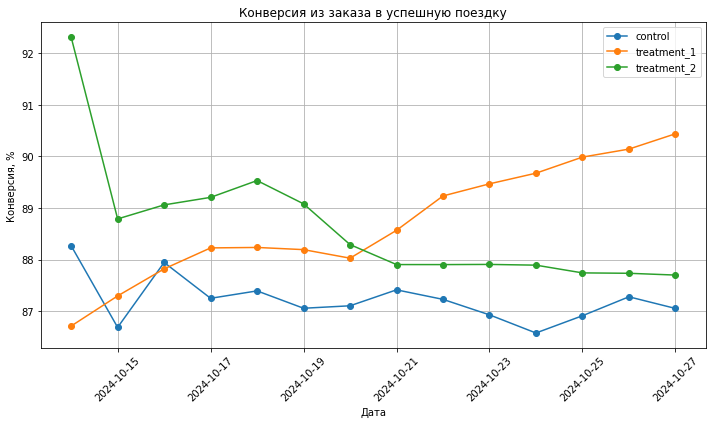

In [5]:
# Загрузка и подготовка данных
data_exp_orders = pd.read_csv('тут_была_ссылка')
data_exp_orders['order_time'] = pd.to_datetime(data_exp_orders['order_time'])

# Пустой список для результатов
records = []

# Формируем лист дат для цикла и сортируем его
date_list = data_exp_orders['order_time'].dt.date.unique()
date_list.sort()

# Конверсия из создания заказа в успешную поездку
for current_date in date_list:
   # Заказы до текущей даты включительно
   orders_to_date = data_exp_orders[data_exp_orders['order_time'].dt.date <= current_date]  
   # Фильтрация по статусу
   completed_orders_to_date = orders_to_date[orders_to_date['status'] == 'completed']

   # Общее количество заказов в каждой группе, столбец с расчётом должен называться total_orders
   total_orders_by_group = orders_to_date.groupby('group_name')['order_id'].nunique().reset_index()
   # Переименование столбца
   total_orders_by_group = total_orders_by_group.rename(columns={'order_id': 'total_orders'})

   # Общее количество завершённых заказов в каждой группе, столбец с расчётом должен называться completed_orders
   completed_orders_by_group = completed_orders_to_date.groupby('group_name')['order_id'].nunique().reset_index()   
# Переименование столбца
   completed_orders_by_group = completed_orders_by_group.rename(columns={'order_id': 'completed_orders'})

   # Объединение и расчёт конверсии
   df_merged_orders = pd.merge(total_orders_by_group, completed_orders_by_group, on='group_name', how='left')
   df_merged_orders['conversion'] = df_merged_orders['completed_orders'] / df_merged_orders['total_orders'] * 100

   df_merged_orders['date'] = current_date
   records.append(df_merged_orders)

# Собираем всё в итоговый датафрейм
conversion_df = pd.concat(records, ignore_index=True)

# Строим график
plt.figure(figsize=(10, 6))
for group in conversion_df['group_name'].unique():
   group_data = conversion_df[conversion_df['group_name'] == group]
   plt.plot(group_data['date'],group_data['conversion'],marker='o', label=group)
plt.title('Конверсия из заказа в успешную поездку')
plt.xlabel('Дата')
plt.ylabel('Конверсия, %')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Выводы по графику:**

*- Группа `treatment_1` демонстрирует устойчивый рост конверсии после 20 октября, к концу периода показывает лучшие результаты*

*- Группа `control` остаётся стабильной на всём протяжении эксперимента (хорошая опорная точка)*

*- До 20 октября все группы показывали схожую динамику*

### Кумулятивное значение барьерной метрики

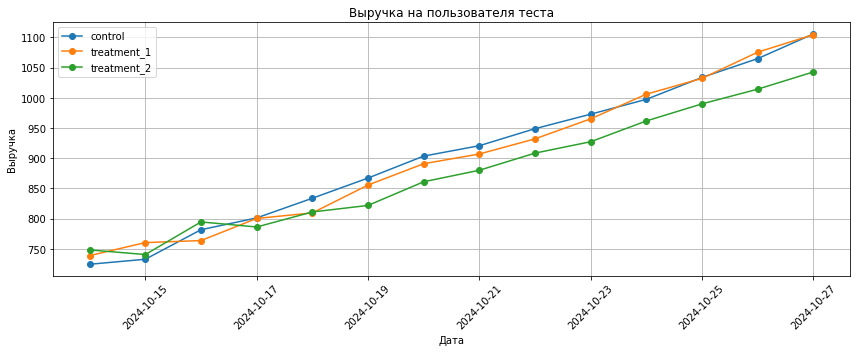

In [6]:
# Загрузка и подготовка данных
data_exp_orders = pd.read_csv('тут_была_ссылка')
data_exp_orders['order_time'] = pd.to_datetime(data_exp_orders['order_time'])

# Пустой список для результатов
records = []

# Формируем лист дат для цикла и сортируем его
date_list = data_exp_orders['order_time'].dt.date.unique()
date_list.sort()

# Выручка на пользователя теста
for current_date in date_list:
   # Выполненные заказы до текущей даты включительно
   completed_orders_to_date = data_exp_orders[data_exp_orders['order_time'].dt.date <= current_date]
   # Фильтрация по статусу
   completed_orders_to_date = completed_orders_to_date[completed_orders_to_date['status'] == 'completed']

   # Суммарная выручка по группам
   summa_by_group = completed_orders_to_date.groupby('group_name')['paid_amt'].sum().reset_index()
   # Переименование столбца
   summa_by_group = summa_by_group.rename(columns={'paid_amt': 'revenue_total'})

   # Количество уникальных пользователей, совершивших заказ, по группам
   users_by_group = completed_orders_to_date.groupby('group_name')['user_id'].nunique().reset_index()
   # Переименование столбца
   users_by_group = users_by_group.rename(columns={'user_id': 'users_total'})

   # Объединение и расчёт выручки на пользователя
   df_merged_orders = pd.merge(summa_by_group, users_by_group, how='outer', on='group_name')
   df_merged_orders['revenue_per_user'] = df_merged_orders['revenue_total'] / df_merged_orders['users_total']

   df_merged_orders['date'] = current_date
   records.append(df_merged_orders)

# Собираем в итоговый датафрейм
revenue_df = pd.concat(records)

# Строим график
plt.figure(figsize=(12, 5))

for group in revenue_df['group_name'].unique():
   group_data = revenue_df[revenue_df['group_name'] == group]
   plt.plot(group_data['date'], group_data['revenue_per_user'], marker='o', label=group)

plt.title('Выручка на пользователя теста')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Выводы по графику:**

*- У группы `treatment_2` барьерная метрика ухудшается (значения ниже контрольной группы)*

*- Группа `treatment_1` демонстрирует схожую с контролем динамику, к концу периода даже опережает контроль*

*- Барьерная метрика в группе `treatment_1` не снижается*

## Подводим итоги теста

### Итоги теста. Расчёт ключевой метрики

In [7]:
# Настройки отображения DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Загрузка данных
data_exp_orders = pd.read_csv('тут_была_ссылка')
data_exp_orders['order_time'] = pd.to_datetime(data_exp_orders['order_time'])

# Расчитываем числитель и знаменатель метрики через группировку и лямбду
df_test = data_exp_orders.groupby(['user_id', 'group_name'], as_index=False).agg(
   total_rides=('order_id', 'count'),
   successful_rides=('status', lambda x: x.eq('completed').sum())
)

# Получаем список всех уникальных групп
groups = sorted(df_test['group_name'].unique())

# Создаём словарь для хранения данных по группам
group_data = {}
for group in groups:
   group_data[group] = df_test[df_test['group_name'] == group]

# Создаём список для хранения результатов
results = []

# Проводим попарные сравнения всех групп
for i in range(len(groups)):
   for j in range(i + 1, len(groups)):
       group1 = groups[i]
       group2 = groups[j]

       # Расчет линейной метрики
       ratio = group_data[group1]['successful_rides'].sum() / group_data[group1]['total_rides'].sum()
       lin_metric1 = group_data[group1]['successful_rides'] - ratio * group_data[group1]['total_rides']
       lin_metric2 = group_data[group2]['successful_rides'] - ratio * group_data[group2]['total_rides']

       # Статистический тест
       _, p_value = ttest_ind(lin_metric1, lin_metric2)

       # Расчет метрик
       mean1 = group_data[group1]['successful_rides'].sum() / group_data[group1]['total_rides'].sum()
       mean2 = group_data[group2]['successful_rides'].sum() / group_data[group2]['total_rides'].sum()

       # Добавление результатов
       results.append({
           'Group A': group1,
           'Group B': group2,
           'p-value': p_value,
           'Mean A': mean1,
           'Mean B': mean2,
           'Absolute Lift': mean2 - mean1,
           'Relative Lift (%)': (mean2 / mean1 - 1) * 100
       })

# Создаём DataFrame из результатов
results_df = pd.DataFrame(results)

# Выводим результаты
print("Результаты сравнения групп:")
print(results_df)

Результаты сравнения групп:
       Group A      Group B   p-value    Mean A    Mean B  Absolute Lift  Relative Lift (%)
0      control  treatment_1  0.000182  0.870543  0.904366       0.033823           3.885230
1      control  treatment_2  0.516517  0.870543  0.877003       0.006460           0.742035
2  treatment_1  treatment_2  0.003372  0.904366  0.877003      -0.027363          -3.025642


**Вывод:** *Ключевая метрика в группе `treatment_1` статистически значимо выше, чем в группах `control` и `treatment_2`. Группа `treatment_2` не показала значимых отличий от контроля.*

### Итоги теста. Вспомогательная метрика 1

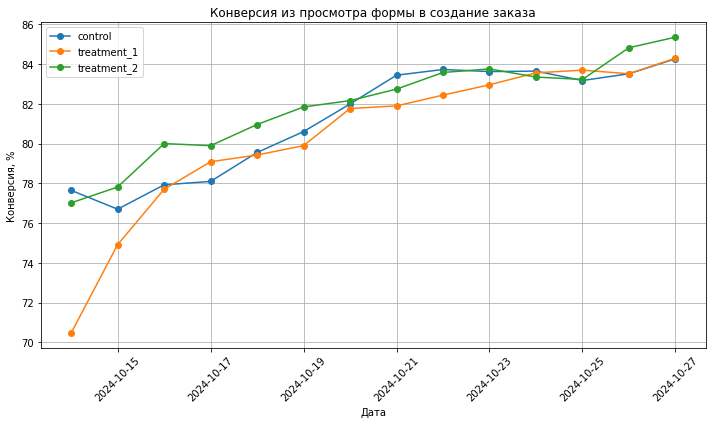

In [8]:
data_exp_events = pd.read_csv('тут_была_ссылка')
data_exp_events['time'] = pd.to_datetime(data_exp_events['time'])

# Пустой список для результатов
records = []

# Формируем лист дат для цикла и сортируем его
date_list = data_exp_events['time'].dt.date.unique()
date_list.sort()

# Конверсия из просмотра формы в создание заказа
for current_date in date_list:
   # События до текущей даты включительно
   events_to_date = data_exp_events[data_exp_events['time'].dt.date <= current_date]
   # Фильтруем order_initiate
   initiated_orders_to_date = events_to_date[events_to_date['event_name'] == 'order_initiate']
   # Фильтруем order_create
   created_orders_to_date = events_to_date[events_to_date['event_name'] == 'order_create']

   # Общее количество пользователей, которые открыли форму заказа, в каждой группе. Столбец с расчётом назовите users_initiated
   initiated_users_by_group = initiated_orders_to_date.groupby('group_name')['user_id'].nunique().reset_index()
   # Переименовать столбец
   initiated_users_by_group = initiated_users_by_group.rename(columns={'user_id': 'users_initiated'})

   # Количество пользователей, которые создали заказ, в каждой группе. Столбец с расчётом назовите users_created
   created_users_by_group = created_orders_to_date.groupby('group_name')['user_id'].nunique().reset_index()
   # Переименовать столбец
   created_users_by_group = created_users_by_group.rename(columns={'user_id': 'users_created'})

   # Объединение и расчёт конверсии
   df_merged_events = pd.merge(initiated_users_by_group, created_users_by_group, how='outer', on='group_name')
   df_merged_events['conversion'] = 100 * df_merged_events['users_created'] / df_merged_events['users_initiated']

   df_merged_events['date'] = current_date
   records.append(df_merged_events)

# Собираем в итоговый датафрейм
conversion_df = pd.concat(records)

# Строим график
plt.figure(figsize=(10, 6))
for group in conversion_df['group_name'].unique():
   group_data = conversion_df[conversion_df['group_name'] == group]
   plt.plot(group_data['date'], group_data['conversion'], marker='o', label=group)
plt.title('Конверсия из просмотра формы в создание заказа')
plt.xlabel('Дата')
plt.ylabel('Конверсия, %')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Вывод:** *Метрика не показала серьёзных отклонений в тестовых группах. Есть различия только в первый день, далее метрика выравнивается.*

### Итоги теста. Вспомогательная метрика 2

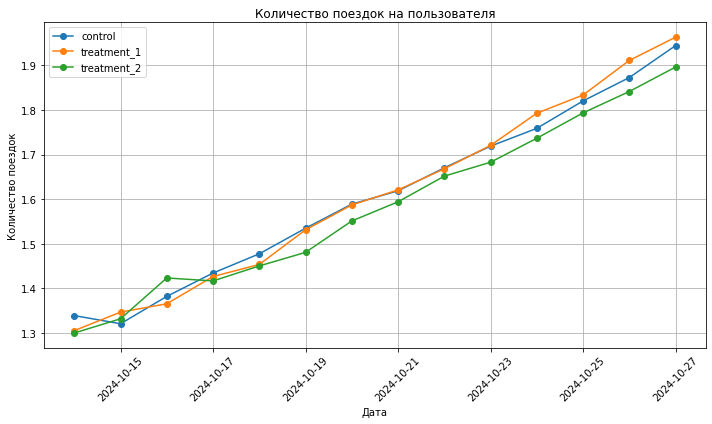

In [9]:
data_exp_orders = pd.read_csv('тут_была_ссылка')
data_exp_orders['order_time'] = pd.to_datetime(data_exp_orders['order_time'])

# Пустой список для результатов
records = []

# Формируем лист дат для цикла и сортируем его
date_list = data_exp_orders['order_time'].dt.date.unique()
date_list.sort()

# Конверсия из просмотра формы в создание заказа
for current_date in date_list:
   # Выполненные заказы до текущей даты включительно
   completed_orders_to_date = data_exp_orders[data_exp_orders['order_time'].dt.date <= current_date]
   # Фильтрация по статусу
   completed_orders_to_date = completed_orders_to_date[completed_orders_to_date['status'] == 'completed']

   # Количество заказов (поездок) всего. Столбец с расчётом — orders_total
   orders_by_group = completed_orders_to_date.groupby('group_name')['order_id'].nunique().reset_index()
   # Переименовать столбец
   orders_by_group = orders_by_group.rename(columns={'order_id': 'orders_total'})

   # Количество уникальных пользователей, совершивших заказ, по группам. Столбец с расчётом — users_total
   users_by_group = completed_orders_to_date.groupby('group_name')['user_id'].nunique().reset_index()
   # Переименовать столбец
   users_by_group = users_by_group.rename(columns={'user_id': 'users_total'})

   # Объединение и расчёт количества поездок на пользователя
   df_merged_orders = pd.merge(orders_by_group, users_by_group, how='outer', on='group_name')

   df_merged_orders['trips_per_user_to_date'] = df_merged_orders['orders_total'] / df_merged_orders['users_total']

   df_merged_orders['date'] = current_date
   records.append(df_merged_orders)

# Собираем в итоговый датафрейм
trips_number_df = pd.concat(records)

# Строим график
plt.figure(figsize=(10, 6))

for group in trips_number_df['group_name'].unique():
   group_data = trips_number_df[trips_number_df['group_name'] == group]
   plt.plot(group_data['date'], group_data['trips_per_user_to_date'], marker='o', label=group)

plt.title('Количество поездок на пользователя')
plt.xlabel('Дата')
plt.ylabel('Количество поездок')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Вывод:** *Изменения в поведении метрики отсутствуют. Количество поездок на пользователя остаётся стабильным во всех группах.*

## Оцениваем результаты теста

###  Основные результаты

| Группа | Ключевая метрика | Барьерная метрика | Статус |
|--------|------------------|-------------------|--------|
| **treatment_1** | +3.89% (p < 0.001) | Не ухудшилась | Успех |
| **treatment_2** | +0.74% (p = 0.516) | Ухудшается | Неэффективна |

###  Ключевые выводы

1. **Гипотеза подтвердилась** — более точный прогноз времени ожидания действительно повышает качество пользовательского опыта и увеличивает вероятность завершения заказа поездкой.

2. **Лучший вариант — treatment_1**:
   - Статистически значимый рост ключевой метрики на **3.89%** относительно контроля
   - Барьерная метрика (выручка на пользователя) не ухудшилась
   - Вспомогательные метрики стабильны

3. **Вариант treatment_2 неэффективен**:
   - Отсутствие статистически значимого роста ключевой метрики
   - Ухудшение барьерной метрики (выручка на пользователя снижается)
   - Не рекомендуется к внедрению

4. **Эффект соответствует ожиданиям**:
   - Рост конверсии (3.89%) соответствует целевому MDE (4%)
   - Эффект заметный, но не революционный

###  Рекомендации

**Внедрить вариант treatment_1 для всех пользователей**

Рекомендуется:
- Постепенный rollout (например, 50% → 100% с мониторингом метрик)
- Дальнейший анализ влияния на различные сегменты пользователей
- Исследование возможности улучшения treatment_2 или его отказ

---

## Презентация результатов (тезисы для старшего аналитика)

1. **Эксперимент показал статистически значимый положительный результат** для группы `treatment_1` в сравнении с группами `control` и `treatment_2`.

2. **Ключевая метрика в варианте `treatment_1` улучшилась на 3.89%** относительно контрольной группы (p < 0.001).

3. **Вспомогательные метрики не показали серьёзного ухудшения** в группе `treatment_1` относительно контроля:
   - Конверсия из просмотра формы в создание заказа стабильна
   - Количество поездок на пользователя не изменилось

4. **Группа `treatment_2` не показала статистически значимых различий** с контрольной группой, при этом барьерная метрика (выручка) ухудшается.

5. **Рекомендовано внедрение фичи для всех пользователей в варианте `treatment_1`**.